In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import control as ctl

In [22]:
df  = pd.read_csv('DataBase.csv')
bkp = df
df.head()

,time,MRU1,MRU2
0,0.003654,"{'ax': -6200, 'ay': -2392, 'az': 18076, 'gx': ...","{'ax': 0.225586, 'ay': 0.15625, 'az': -1.03759..."
1,0.020094,"{'ax': -7180, 'ay': -2368, 'az': 17100, 'gx': ...","{'ax': 0.244141, 'ay': 0.155762, 'az': -1.0698..."
2,0.036285,"{'ax': -5796, 'ay': -1260, 'az': 17916, 'gx': ...","{'ax': 0.193848, 'ay': 0.054688, 'az': -1.0693..."
3,0.052523,"{'ax': -4044, 'ay': 924, 'az': 15000, 'gx': -7...","{'ax': 0.15625, 'ay': -0.055664, 'az': -0.9760..."
4,0.068771,"{'ax': -2924, 'ay': 700, 'az': 13148, 'gx': -6...","{'ax': 0.106934, 'ay': -0.043945, 'az': -0.953..."


In [23]:
data = []

for i, row in df.iterrows():
    mru1 = eval(row['MRU1'])
    mru2 = eval(row['MRU2'])
    dic = {}

    for key, value in mru1.items():
        dic.update({f'mru1_{key}': value})

    for key, value in mru2.items():
        dic.update({f'mru2_{key}': value})

    dic.update({'time': row.time})
    data.append(dic)

df = pd.DataFrame(data)
df

,mru1_ax,mru1_ay,mru1_az,mru1_gx,mru1_gy,mru1_gz,mru2_ax,mru2_ay,mru2_az,mru2_gx,mru2_gy,mru2_gz,time
0,-6200,-2392,18076,-2801,524,12392,0.225586,0.156250,-1.037598,18.798830,-10.498050,-95.642090,0.003654
1,-7180,-2368,17100,-4954,2617,9622,0.244141,0.155762,-1.069824,34.362790,-24.841310,-75.317380,0.020094
2,-5796,-1260,17916,-6210,403,7348,0.193848,0.054688,-1.069336,44.555660,-6.286621,-59.753420,0.036285
3,-4044,924,15000,-7025,659,6196,0.156250,-0.055664,-0.976074,49.560550,-11.230470,-52.612300,0.052523
4,-2924,700,13148,-6079,1884,5546,0.106934,-0.043945,-0.953613,40.344240,-19.409180,-48.339840,0.068771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,-1332,1220,16176,174,-376,-141,0.017090,-0.081055,-1.032227,-2.380371,-2.563477,-1.281738,18.085546
1113,-1448,1200,16132,-160,-449,-147,0.028320,-0.079102,-1.036621,0.366211,-2.014160,-1.525879,18.101838
1114,-1684,1056,15896,-326,-444,-224,0.036133,-0.067383,-1.035156,0.671387,-1.953125,-0.366211,18.118046
1115,-1732,1052,15964,-182,-532,-397,0.041992,-0.068359,-1.037598,-0.061035,-0.671387,0.305176,18.134333


In [24]:
key = 'ax'

df = pd.DataFrame({
    'time': df.time,
    's1': df[f'mru1_{key}'],
    's2': df[f'mru2_{key}']
})

df

,time,s1,s2
0,0.003654,-6200,0.225586
1,0.020094,-7180,0.244141
2,0.036285,-5796,0.193848
3,0.052523,-4044,0.156250
4,0.068771,-2924,0.106934
...,...,...,...
1112,18.085546,-1332,0.017090
1113,18.101838,-1448,0.028320
1114,18.118046,-1684,0.036133
1115,18.134333,-1732,0.041992


In [25]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


dt = 0.005
df = normalizeTable(df, 'time', dt)
df.head()

,time,s1,s2
0,0.000,-6200,0.225586
1,0.005,-6200,0.225586
2,0.010,-6200,0.225586
3,0.015,-6200,0.225586
4,0.020,-7180,0.244141


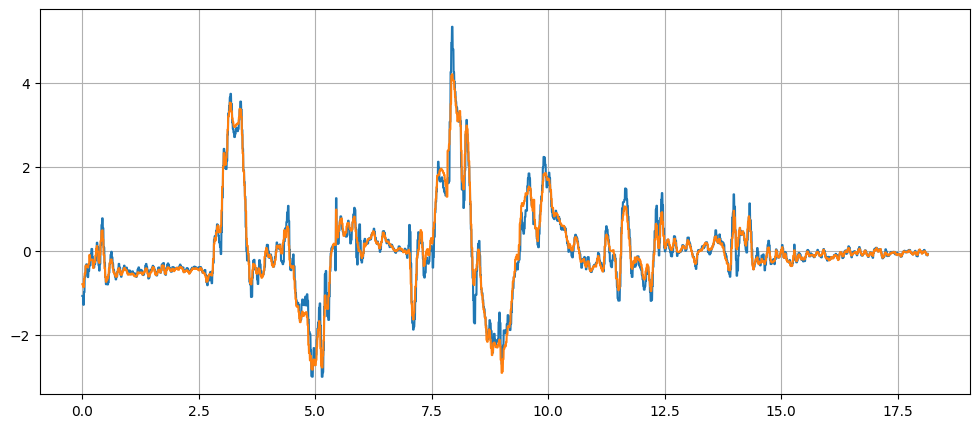

In [26]:
def normalize(data):
    return (data - np.mean(data))/np.std(data)

df['s1'] = normalize(df.s1)
df['s2'] = (-1)*normalize(df.s2)

plt.figure(figsize=(12, 5))
plt.plot(df.time, df.s1.values)
plt.plot(df.time, df.s2.values)
plt.grid()

# FILTRANDO

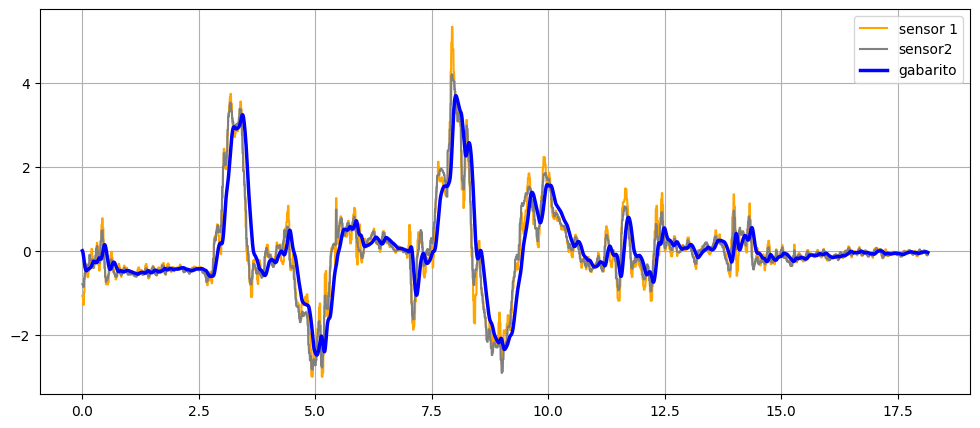

In [27]:
class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]


filter1 = LaplaceFilter(Ts=0.2, UP=0.05, dt=dt)
filter2 = LaplaceFilter(Ts=0.6, UP=0.05, dt=dt)
y1 = np.array([filter1.update(val) for val in df.s1])
y2 = np.array([filter2.update(val) for val in df.s2])
df['target'] = (y1 + y2)/2

plt.figure(figsize=(12, 5))
plt.plot(df.time, df.s1.values, color='orange', label='sensor 1')
plt.plot(df.time, df.s2.values, color='gray', label='sensor2')
plt.plot(df.time, df.target.values, color='blue', linewidth=2.5, label='gabarito')
plt.legend()
plt.grid()

# ADICIONANDO OS ESTADOS

In [28]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}[n-0]'] = table[key]

    for i in range(1, n):
        table[f'{var}[n-{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}[n-0]'] + [f'{var}[n-{i}]' for i in range(1, n)]
    return table[columns]

size = 50

In [29]:
s1 = getStates(df, 's1', 's1', size)
s1.head()

,s1[n-0],s1[n-1],s1[n-2],s1[n-3],s1[n-4],s1[n-5],s1[n-6],s1[n-7],s1[n-8],s1[n-9],...,s1[n-40],s1[n-41],s1[n-42],s1[n-43],s1[n-44],s1[n-45],s1[n-46],s1[n-47],s1[n-48],s1[n-49]
0,-1.078027,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.078027,-1.078027,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.078027,-1.078027,-1.078027,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.078027,-1.078027,-1.078027,-1.078027,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.290069,-1.078027,-1.078027,-1.078027,-1.078027,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
s2 = getStates(df, 's2', 's2', size)
s2.head()

,s2[n-0],s2[n-1],s2[n-2],s2[n-3],s2[n-4],s2[n-5],s2[n-6],s2[n-7],s2[n-8],s2[n-9],...,s2[n-40],s2[n-41],s2[n-42],s2[n-43],s2[n-44],s2[n-45],s2[n-46],s2[n-47],s2[n-48],s2[n-49]
0,-0.799162,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.799162,-0.799162,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.799162,-0.799162,-0.799162,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.799162,-0.799162,-0.799162,-0.799162,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.869009,-0.799162,-0.799162,-0.799162,-0.799162,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df = pd.concat([df.time, s1, s2, df.target], axis=1)
df

,time,s1[n-0],s1[n-1],s1[n-2],s1[n-3],s1[n-4],s1[n-5],s1[n-6],s1[n-7],s1[n-8],...,s2[n-41],s2[n-42],s2[n-43],s2[n-44],s2[n-45],s2[n-46],s2[n-47],s2[n-48],s2[n-49],target
0,0.000,-1.078027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002785
1,0.005,-1.078027,-1.078027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.013400
2,0.010,-1.078027,-1.078027,-1.078027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.033104
3,0.015,-1.078027,-1.078027,-1.078027,-1.078027,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.060003
4,0.020,-1.290069,-1.078027,-1.078027,-1.078027,-1.078027,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.092943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,18.130,-0.100902,-0.100902,-0.100902,-0.100902,-0.049839,-0.049839,-0.049839,-0.024740,-0.024740,...,-0.100710,-0.100710,-0.097036,-0.097036,-0.097036,-0.058437,-0.058437,-0.058437,-0.029027,-0.032979
3627,18.135,-0.111288,-0.100902,-0.100902,-0.100902,-0.100902,-0.049839,-0.049839,-0.049839,-0.024740,...,-0.100710,-0.100710,-0.100710,-0.097036,-0.097036,-0.097036,-0.058437,-0.058437,-0.058437,-0.035500
3628,18.140,-0.111288,-0.111288,-0.100902,-0.100902,-0.100902,-0.100902,-0.049839,-0.049839,-0.049839,...,-0.100710,-0.100710,-0.100710,-0.100710,-0.097036,-0.097036,-0.097036,-0.058437,-0.058437,-0.038367
3629,18.145,-0.111288,-0.111288,-0.111288,-0.100902,-0.100902,-0.100902,-0.100902,-0.049839,-0.049839,...,-0.036379,-0.100710,-0.100710,-0.100710,-0.100710,-0.097036,-0.097036,-0.097036,-0.058437,-0.041502


# MODELO PREDITIVO

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [33]:
xData = df.drop(columns=['time', 'target'])
yData = df.target.values
xData.head()

,s1[n-0],s1[n-1],s1[n-2],s1[n-3],s1[n-4],s1[n-5],s1[n-6],s1[n-7],s1[n-8],s1[n-9],...,s2[n-40],s2[n-41],s2[n-42],s2[n-43],s2[n-44],s2[n-45],s2[n-46],s2[n-47],s2[n-48],s2[n-49]
0,-1.078027,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.078027,-1.078027,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.078027,-1.078027,-1.078027,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.078027,-1.078027,-1.078027,-1.078027,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.290069,-1.078027,-1.078027,-1.078027,-1.078027,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### REGRESSÃO LINEAR

score: 0.999


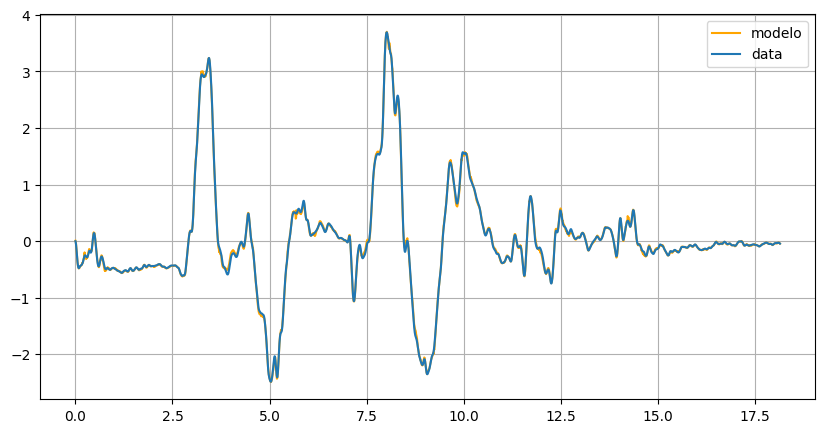

In [34]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = linearRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()

### REGRESSÃO POLINOMIAL

score: 0.740


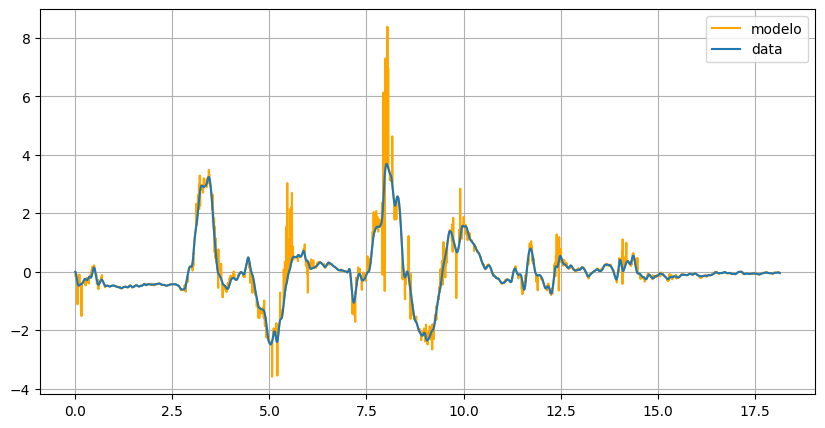

In [35]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = polinomialRegression(xData, yData, degree=2)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()

### ÁRVORE DE DECISÃO

score: 0.996


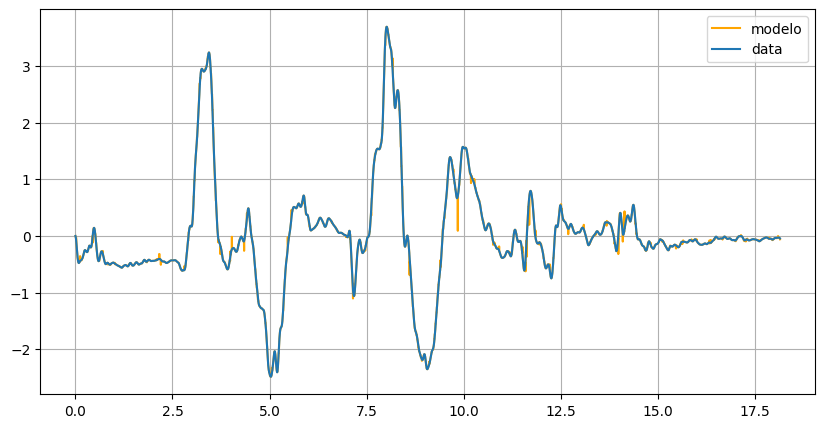

In [36]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = decisionTreeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()

### RANDOM FOREST

score: 0.998


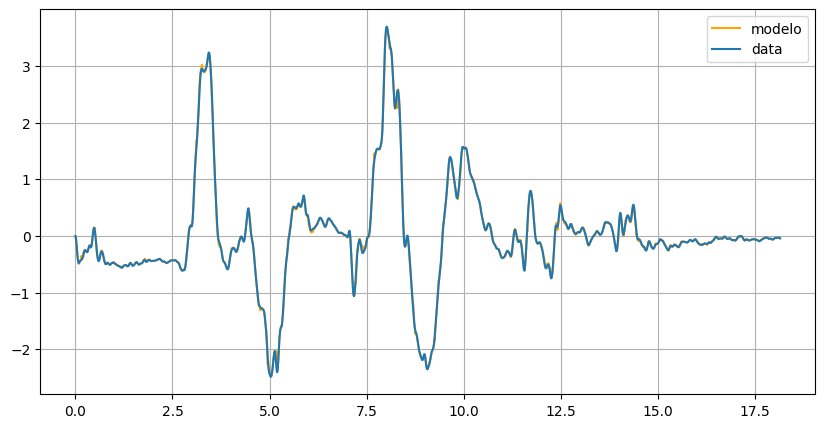

In [37]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = randomForestRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

score: 0.996


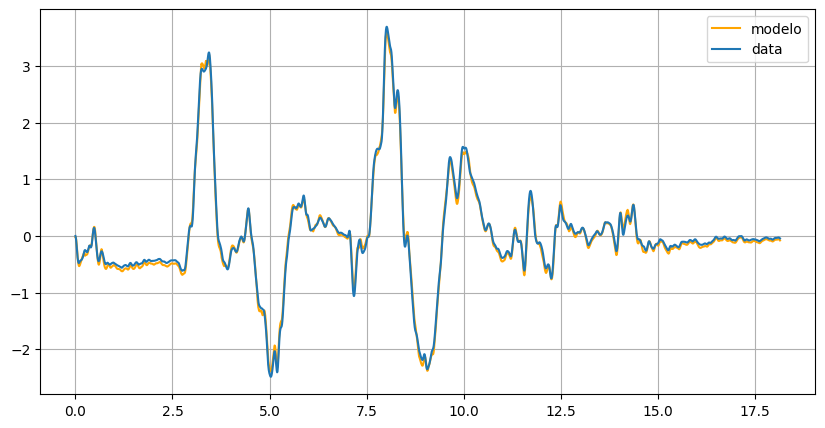

In [38]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = SVR(kernel='rbf')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = supportVectorRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()

### RIDGE REGRESSOR

score: 0.999


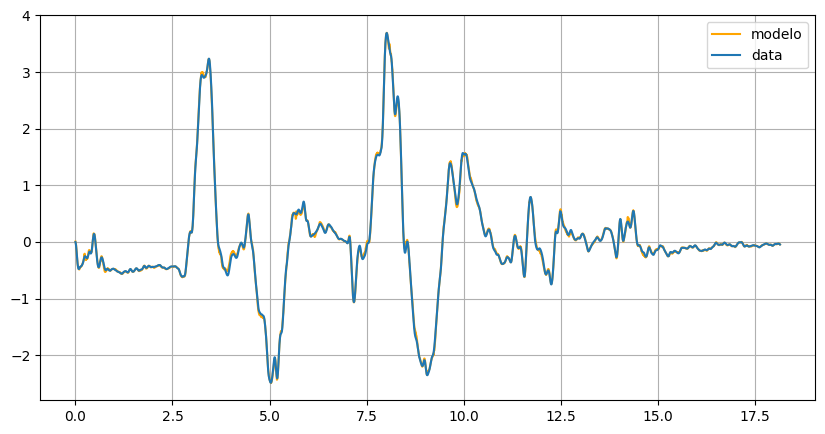

In [39]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = ridgeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()

### GRADIENT BOOSTER

### K-NEAREST NEIGHBORS

score: 0.999


c:\Users\march\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\subp

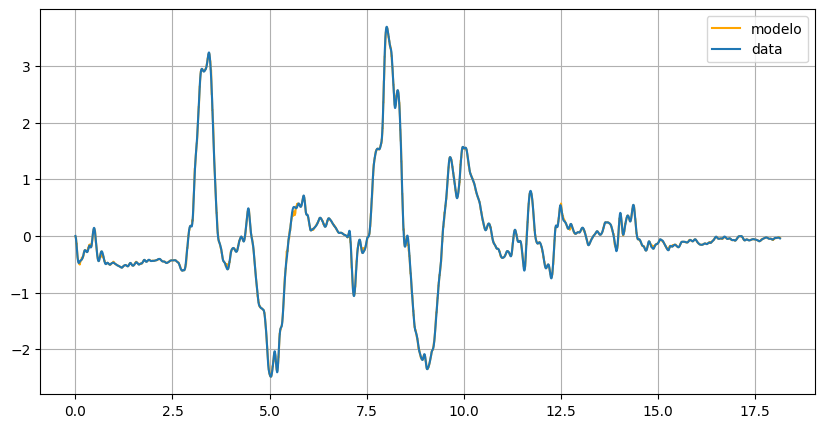

In [40]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = knnRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yModel, color='orange', label='modelo')
plt.plot(df.time, yData, label='data')
plt.legend(), plt.grid()
plt.show()